# Manual Neural Network

In this notebook we will manually build out a neural network that mimics the TensorFlow API. This will greatly help your understanding when working with the real TensorFlow!

____
### Quick Note on Super() and OOP

In [4]:
class SimpleClass():
    
    def __init__(self,str_input):
        print("SIMPLE"+str_input)

In [5]:
class ExtendedClass(SimpleClass):
    
    def __init__(self):
        print('EXTENDED')

In [6]:
s = ExtendedClass()

EXTENDED


In [7]:
class ExtendedClass(SimpleClass):
    
    def __init__(self):
        
        super().__init__(" My String")
        print('EXTENDED')

In [8]:
s = ExtendedClass()

SIMPLE My String
EXTENDED


________

## Operation

In [9]:
class Operation():
    """
    An Operation is a node in a "Graph". TensorFlow will also use this concept of a Graph.
    
    This Operation class will be inherited by other classes that actually compute the specific
    operation, such as adding or matrix multiplication.
    """
    
    def __init__(self, input_nodes = []):
        """
        Intialize an Operation
        """
        self.input_nodes = input_nodes # The list of input nodes
        self.output_nodes = [] # List of nodes consuming this node's output
        
        # For every node in the input, we append this operation (self) to the list of
        # the consumers of the input nodes
        for node in input_nodes:
            node.output_nodes.append(self)
        
        # There will be a global default graph (TensorFlow works this way)
        # We will then append this particular operation
        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)
  
    def compute(self):
        """ 
        This is a placeholder function. It will be overwritten by the actual specific operation
        that inherits from this class.
        
        """
        
        pass

## Example Operations

### Addition

In [10]:
class add(Operation):
    
    def __init__(self, x, y):
         
        super().__init__([x, y])

    def compute(self, x_var, y_var):
         
        self.inputs = [x_var, y_var]
        return x_var + y_var

### Multiplication

In [11]:
class multiply(Operation):
     
    def __init__(self, a, b):
        
        super().__init__([a, b])
    
    def compute(self, a_var, b_var):
         
        self.inputs = [a_var, b_var]
        return a_var * b_var

### Matrix Multiplication

In [12]:
class matmul(Operation):
     
    def __init__(self, a, b):
        
        super().__init__([a, b])
    
    def compute(self, a_mat, b_mat):
         
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

## Placeholders

In [13]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a value for computing the output in the Graph.
    """
    
    def __init__(self):
        
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)

## Variables

In [14]:
class Variable():
    """
    This variable is a changeable parameter of the Graph.
    """
    
    def __init__(self, initial_value = None):
        
        self.value = initial_value
        self.output_nodes = []
        
         
        _default_graph.variables.append(self)

## Graph

In [15]:
class Graph():
    
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_default(self):
        """
        Sets this Graph instance as the Global Default Graph
        """
        global _default_graph
        _default_graph = self

## A Basic Graph

$$ z = Ax + b $$

With A=10 and b=1

$$ z = 10x + 1 $$

Just need a placeholder for x and then once x is filled in we can solve it!

In [16]:
g = Graph()

In [17]:
g.set_as_default()

In [18]:
A = Variable(10)

In [19]:
b = Variable(1)

In [20]:
# Will be filled out later
x = Placeholder()

In [21]:
y = multiply(A,x)

In [22]:
z = add(y,b)

## Session

In [23]:
import numpy as np

### Traversing Operation Nodes

In [24]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b). Feel free to copy and paste this code.
    It is not super important for understanding the basic fundamentals of deep learning.
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

In [25]:
isinstance('salam',int)

False

In [26]:
class Session:
    
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to input values (the data)  
        """
        
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:

            if type(node) == Placeholder:
                
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                
                node.output = node.value
                
            else: # Operation
                
                node.inputs = [
        input_node.output for input_node in node.input_nodes]

                 
                node.output = node.compute(*node.inputs)
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output




In [27]:
sess = Session()

In [28]:
result = sess.run(operation=z,feed_dict={x:10})

In [29]:
result

101

In [30]:
10*10 + 1

101

** Looks like we did it! **

In [31]:
g = Graph()

g.set_as_default()

A = Variable([[10,20],[30,40]])
b = Variable([1,1])

x = Placeholder()

y = matmul(A,x)

z = add(y,b)


In [32]:
sess = Session()

In [33]:
result = sess.run(operation=z,feed_dict={x:10})

In [34]:
result

array([[101, 201],
       [301, 401]])

## Activation Function

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [37]:
sample_z = np.linspace(-10,10,100)
sample_a = sigmoid(sample_z)

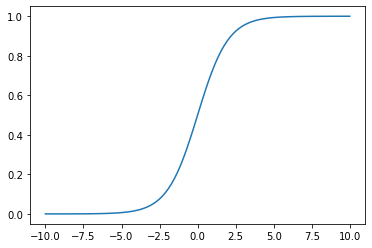

In [38]:
plt.plot(sample_z,sample_a)

#### Sigmoid as an Operation

In [39]:
class Sigmoid(Operation):
 
    
    def __init__(self, z):

        # a is the input node
        super().__init__([z])

    def compute(self, z_val):
        
        return 1/(1+np.exp(-z_val))

## Classification Example

In [40]:
from sklearn.datasets import make_blobs

In [41]:
data = make_blobs(n_samples = 50,n_features=2,
                  centers=2,random_state=75)

In [42]:
data

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

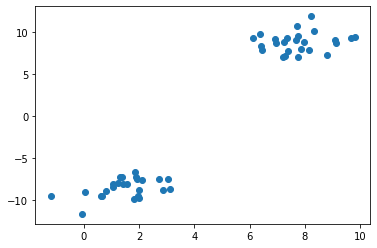

In [43]:
features = data[0]
plt.scatter(features[:,0],features[:,1])

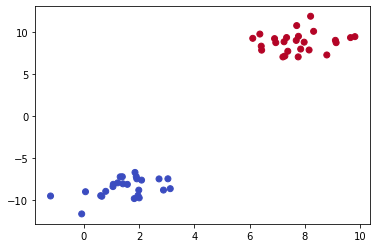

In [45]:
labels = data[1]
plt.scatter(features[:,0],features[:,1],
            c=labels,cmap='coolwarm');

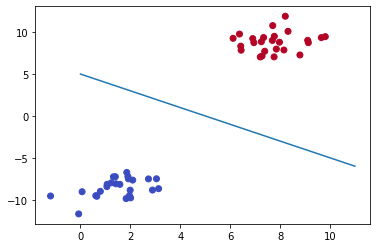

In [46]:
# DRAW A LINE THAT SEPERATES CLASSES
x = np.linspace(0,11,10)
y = -x + 5
plt.scatter(features[:,0],features[:,1],
            c=labels,cmap='coolwarm')
plt.plot(x,y)

## Defining the Perceptron

$$ y = mx + b $$

$$ y = -x + 5 $$

$$ f1 = mf2 + b , m=1$$

$$ f1 = -f2 + 5 $$

$$ f1 + f2 - 5 = 0 $$


### Convert to a Matrix Representation of Features

$$ w^Tx + b = 0 $$

$$   \Big(1, 1\Big)f - 5 = 0 $$

Then if the result is > 0 its label 1, if it is less than 0, it is label=0



### Example Point

Let's say we have the point f1=2 , f2=2 otherwise stated as (8,10). Then we have:

$$ 
\begin{pmatrix} 
1 , 1
\end{pmatrix} 
\begin{pmatrix} 
8 \\
10
\end{pmatrix} - 5 =  $$

In [47]:
np.array([1, 1]).dot(np.array([[8],[10]])) - 5

array([13])

Or if we have (4,-10)

In [48]:
np.array([1,1]).dot(np.array([[4],[-10]])) - 5

array([-11])

### Using an Example Session Graph

In [49]:
g = Graph()

In [50]:
g.set_as_default()

In [51]:
x = Placeholder()

In [52]:
w = Variable([1,1])

In [53]:
b = Variable(-5)

In [54]:
z = add(matmul(w,x),b)

In [55]:
a = Sigmoid(z)

In [56]:
sess = Session()

In [57]:
sess.run(operation=a,feed_dict={x:[8,10]})

0.999997739675702

In [58]:
sess.run(operation=a,feed_dict={x:[0,-10]})

3.059022269256247e-07